# makemore: part 3

In this part Andrej revisit the MLP implementation making some imprvements and adjustements.

To keep track of al of them i will add comments with a custom emoji.




## 1.- 🍼 Initial Loss

Initializing with random values leads to initial high loss values. The network is highly confident wrong

```python
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
```

With a better initial loss we dont spend initial steps squashing the values


## 2.- 📈 Saturated tanh

Lots of values of our hiddent layer are -1 or 1, due to the h_preactivation has a very big range of values.

Lets see whats happening when backpropagating:

```python
def tanh.backward():
    self.grad += (1-t**2) * out.grad
```
if t=+-1 we are a getting a **0** and *stopping* the backpropagation.

if t=0, the tanh is *inactive*. the grad passes by

This problem can happen in multiple activation functions, who also have this 'tails'

![](activation_function_tails.png)

# 3.- 🪄 Avoid magic numbers or Kaiming init

So, to avoid the initialization and the tanh issue we have endede with something like this

```python
    W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.1  # 📈 desaturating tanh
    b1 = torch.randn(n_hidden,                        generator=g) * 0.01 # 📈 desaturating tanh
    W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # 🍼. Weights should not be 0.
    b2 = torch.randn(vocab_size,                      generator=g) * 0    # 🍼. Not adding bias at initialization
```

How do we get this numbers?

https://arxiv.org/pdf/1502.01852

https://pytorch.org/docs/stable/nn.init.html --> tanh 5/3

Nowadays its no so important to initialize the terms exactly right.

# 4.- 🔔 Batch normalization layer

https://arxiv.org/pdf/1502.03167

BatchNorm stabilizes training by normalizing activations to have zero mean and unit variance. This prevents them from becoming too large and saturating activation functions like tanh.

Usually placed after layers with multiplications (linear or convolutional)

However, we don’t always want activations to be strictly Gaussian, so we introduce trainable parameters:

    bn_gain (γ) – Scales activations after normalization.
    bn_bias (β) – Shifts activations after normalization.

![](batch_norm.png)

### Regularizing effect
Since BatchNorm adjusts each sample based on the mean and std of its batch-partners, this adds slight noise to the activations.

This effect acts as a form of data augmentation, helping the model generalize better.

### Buffer of mean and std
Used for running inferences with a good estimation of mean and std of whole dataset



Nowadays is much more common group normalization or layer normalization
* Layer Normalization (LN) normalizes each sample by looking at all its features, so it works well even with small batches.

* Group Normalization (GN) splits the features into small groups and normalizes each one separately, making it a good middle ground between BatchNorm and LayerNorm.


In [29]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
#Data load. No changes here

#https://datos.gob.es/es/catalogo/a09002970-municipios-de-espana
# We will instead be using names of villages/cities in Spain. Only 8k data
import pandas as pd

# Read the CSV data
df = pd.read_csv("Municipis_d_Espanya.csv", sep=",")

# Function to clean the names
def clean_name(name):
    # If there's a slash, take the first part
    name = name.split('/')[0]
    # If it's in "Last, First" format, swap it to "First Last"
    if ',' in name:
        parts = name.split(', ')
        if len(parts) == 2:
            name = f"{parts[1]} {parts[0]}"
    return name

# Apply the function to clean names
df["Nom"] = df["Nom"].apply(clean_name)

# Extract only the 'Territorio' column as a list
words = df["Nom"].tolist()

print(f"{len(words)} words")

#Simplifying the problem (lowercase and no accents)
import unidecode
import re

print(words[:1])
words = [re.sub(r'[\(\)\'"]', '', unidecode.unidecode(word).lower()) for word in words]
print(words[:1])

8134 words
['Alegría-Dulantzi']
['alegria-dulantzi']


In [31]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: ' ', 2: '-', 3: 'a', 4: 'b', 5: 'c', 6: 'd', 7: 'e', 8: 'f', 9: 'g', 10: 'h', 11: 'i', 12: 'j', 13: 'k', 14: 'l', 15: 'm', 16: 'n', 17: 'o', 18: 'p', 19: 'q', 20: 'r', 21: 's', 22: 't', 23: 'u', 24: 'v', 25: 'w', 26: 'x', 27: 'y', 28: 'z', 0: '.'}
29


In [32]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([85032, 3]) torch.Size([85032])
torch.Size([10606, 3]) torch.Size([10606])
torch.Size([10768, 3]) torch.Size([10768])


In [33]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 300 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
#W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.1  # 📈 desaturating tanh

#We want the std of our data to be gain/sqrt(fan_in) # 📈 desaturating tanh
#https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_
gain_for_tanh=5/3
fan_in=(n_embd * block_size)#By scaling by 1/sqrt(fan_in=n_inputs), you keep the variance of activations approximately constant, preventing saturation.
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * gain_for_tanh/(fan_in**0.5) #* 0.2 # 📈 desaturating tanh
b1 = torch.randn(n_hidden,                        generator=g) * 0.01 # 📈 desaturating tanh
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # 🍼. Weights should not be 0.
b2 = torch.randn(vocab_size,                      generator=g) * 0    # 🍼. Not adding bias at initialization

#🔔 BatchNorm parameters
bngain = torch.ones((1, n_hidden))#🔔 1s but then backprop will modify our originally gaussian distrib 
bnbias = torch.zeros((1, n_hidden))#🔔 0s but then backprop will modify our originally gaussian distrib 

bnmean_running = torch.zeros((1, n_hidden))#🔔0s
bnstd_running = torch.ones((1, n_hidden))#🔔1s
#bn**_running approximates the true dataset mean, not just the batch mean.


parameters = [C, W1, W2, b2, bngain, bnbias]#🔔 bngain and bnbias also train
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

18619


In [34]:
# same optimization as last time
max_steps = 200000
batch_size = 64
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # --forward pass--
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  #hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  hpreact = embcat @ W1 #+ b1 #🔔 Due to the Bnormalization. b1 is now useles
  #hpreact = (hpreact-mean)/std #🔔
  bn_mean_i=hpreact.mean(0, keepdim=True)#🔔
  bn_std_i=hpreact.std(0, keepdim=True)#🔔
  hpreact=(hpreact-bn_mean_i)/(bn_std_i+10e-6)#🔔 little eps preventing /0
  hpreact = bngain*hpreact +bnbias#🔔
       
  with torch.no_grad(): #Only used for tracking bnmean and bnstd. Not used for training
    momentum=0.001 #you can have higher values with bigger batchsizes
    bnmean_running =  (1-momentum) * bnmean_running + momentum * bn_mean_i
    bnstd_running =   (1-momentum) * bnstd_running  + momentum * bn_std_i


  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  #--backward pass--
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  

      0/ 200000: 3.4207
  10000/ 200000: 1.9382
  20000/ 200000: 1.7544
  30000/ 200000: 1.8942
  40000/ 200000: 1.6910
  50000/ 200000: 1.7375
  60000/ 200000: 1.6388
  70000/ 200000: 1.7190
  80000/ 200000: 1.6808
  90000/ 200000: 1.7390
 100000/ 200000: 2.0621
 110000/ 200000: 1.7566
 120000/ 200000: 1.7099
 130000/ 200000: 1.4750
 140000/ 200000: 1.9096
 150000/ 200000: 1.7290
 160000/ 200000: 1.5729
 170000/ 200000: 1.2636
 180000/ 200000: 1.5172
 190000/ 200000: 1.6155


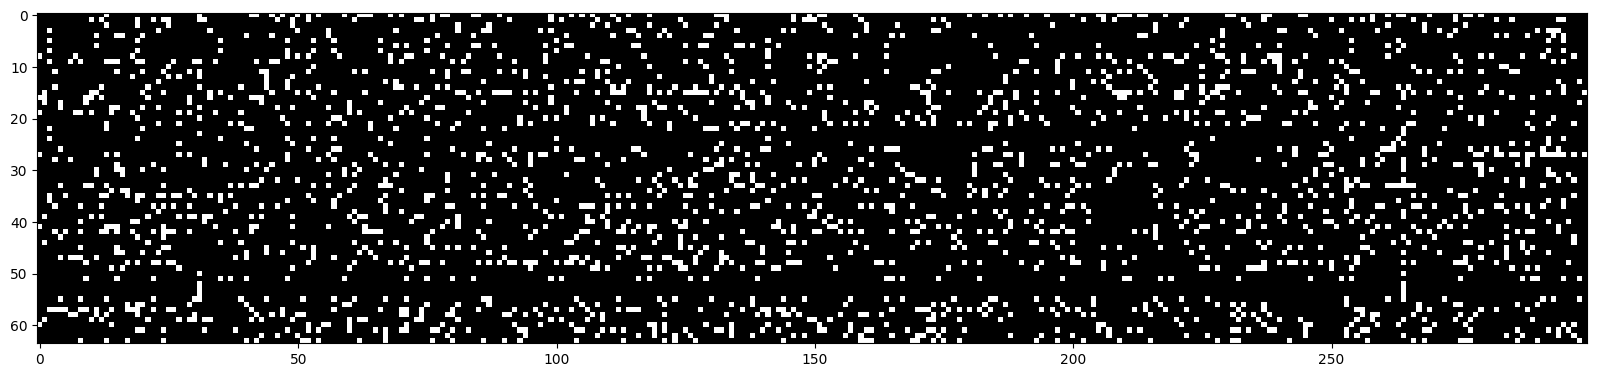

In [35]:
#📈 saturated tanh

plt.figure(figsize=(20,10))

plt.imshow(h.abs() > 0.99, cmap='gray')

In [36]:
#📈 saturated tanh

zero_grad_columns = (h.abs()>0.99).all(dim=0)

# If any column is full of ones
if zero_grad_columns.any():
    print("There is at least one column full of 'ones'.")
else:
    print("No column is entirely 'one'.")


#A column full of ones is equal to a dead neuron. The gradients get destroyed 


No column is entirely 'one'.


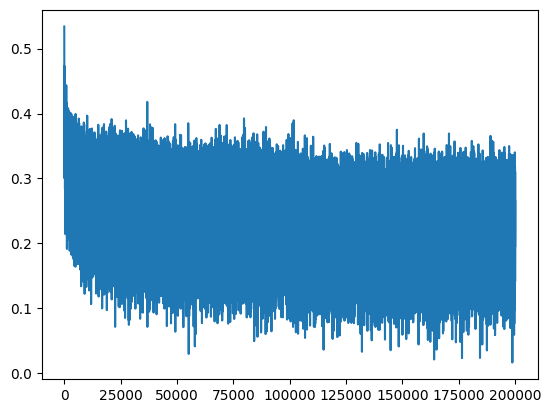

In [37]:
plt.plot(lossi)

In [38]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)


In [39]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias #🔔
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias#🔔
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.618809461593628
val 1.7743667364120483


We achieved a loss of **1.77**, which is smaller than the one in the previous notebook (**1.87**). Although the difference is small, these changes are mainly oriented towards deeper networks.

___

In [53]:
g = torch.Generator().manual_seed(2147483647)

for _ in range(100):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1
      hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias#🔔
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))


truabuenoia de osadienca.
lodos.
purona eneros.
trozlo de arroza de cas.
laua.
riubera.
copa de arlossorihuerras.
pateras.
hontelo.
ampila.
ceenar.
huela.
uruenoia.
ulete.
ternalena.
gamarsuorberadanez eierra.
noelarror.
pilaijo.
gua.
sant.
riu de aratsevilonar.
ara de arraladarra.
sante de arregon de mar.
rio.
guaro de arraba.
valarrorones.
 alcantalalacuide-artolosalacarasui.
salambro.
anxualt egenazerrosa de arro.
trua.
ceralamejueruelada.
erro.
ripalmamblona.
laguiarcui.
beraldea.
palamejuano de linue.
muro de bieteigo.
nua.
obue.
tuea.
ulealrazron.
orsa.
bresa.
ohranjano.
bauerona.
fuena.
jmielo.
buesa.
herroya de obea.
tuer.
huero.
tetama.
segas.
meritlones.
riosepadajuejoseguereelorruesa.
.
pqeria.
ceranosiluena.
lalo de arlana.
atera de cas.
bena.
hmeros.
muria.
car.
munola.
estafe.
gua en i ambruo.
alesada.
xoyuesadroneja de arra-soo.
massarmuexo.
puio de olino.
calejo.
nava.
rua.
glo de onraqela.
gua zresuue.
valdea.
jarara.
jheeixle.
seradilalia.
sau.
maz.
g.
benillua.
nou.
